In [143]:
# ===== Reduced Order Modeling with NGSolve + pyMOR (POD-Galerkin) =====
from ngsolve import *
from ngsolve import Mesh
from ngsolve import x, y, z
from ngsolve.webgui import Draw
from netgen.geom2d import unit_square
from netgen.occ import *

from pymor.algorithms.pod import pod
from pymor.vectorarrays.numpy import NumpyVectorSpace
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np

In [144]:
mesh = Mesh(unit_square.GenerateMesh(maxh=0.1, quad_dominated=True))
# mesh = Mesh(unit_square.GenerateMesh(maxh=0.1))

order = 2
V = VectorH1(mesh,order=order,dirichlet="left")
u, v = V.TnT()

E = 5e6 # Youngs module
nu = 0.25 # Poisson ratio
CDR = [-0.3,0.3] # Corner displacement range
rho = 7850 # Material density
lam = E*nu / ((1+nu)*(1-2*nu))
G  = E / (2*(1+nu))
g = 9.81 # graviational acceleration

In [145]:
mesh = Mesh(unit_square.GenerateMesh(maxh=0.1,quad_dominated=True))

deform = GridFunction(VectorH1(mesh, order=1))

mesh.UnsetDeformation()
deform.Interpolate((x*y*0.3, x*y*0.3))
mesh.SetDeformation(deform)

V = VectorH1(mesh, order=2, dirichlet="left")
u, v = V.TnT()

def eps(w):   return 0.5*(Grad(w)+Grad(w).trans)
def sigma(w): return 2*G*eps(w) + lam*Trace(eps(w))*Id(w.dim)

a = BilinearForm(V)
a += InnerProduct(sigma(u), eps(v))*dx

rho, g = 7850, 9.81
f = LinearForm(V)
f += CoefficientFunction((0,-rho*g)) * v * dx

# Assemble & solve 
gfu = GridFunction(V)
a.Assemble(); f.Assemble()
inv = a.mat.Inverse(V.FreeDofs(), inverse="sparsecholesky")
gfu.vec.data = inv * f.vec

# mesh.UnsetDeformation()
# from ngsolve.webgui import Draw
# Draw(gfu[1],mesh)

In [149]:
DX_MAX, DY_MAX = 0.3, 0.3
N = 5   # grid size in each direction
dx_vals = np.linspace(-DX_MAX, DX_MAX, N)
dy_vals = np.linspace(-DY_MAX, DY_MAX, N)

# make all combinations
mu = [(dx, dy) for dx in dx_vals for dy in dy_vals]

snapshots = []

def solve_full(mu):
    del_x, del_y = mu
    mesh.UnsetDeformation()
    deform.Interpolate((x*y*del_x, x*y*del_y))
    mesh.SetDeformation(deform)
    
    V = VectorH1(mesh, order=2, dirichlet="left")
    u, v = V.TnT()
    a = BilinearForm(V)
    a += InnerProduct(sigma(u), eps(v))*dx

    f = LinearForm(V)
    f += CoefficientFunction((0,-rho*g)) * v * dx
    # Assemble & solve 
    gfu = GridFunction(V)
    a.Assemble(); f.Assemble()
    inv = a.mat.Inverse(V.FreeDofs(), inverse="sparsecholesky")
    gfu.vec.data = inv * f.vec
    return gfu

for i in range(len(mu)):
    gfu = solve_full(mu[i])
    snapshots.append(gfu.vec)


space = NumpyVectorSpace(len(snapshots))
S = space.make_array(np.column_stack(snapshots))   # shape: Ndofs x nsnaps

RB, svals = pod(S)


Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

In [ ]:
# rapid_minimal_pod_check.py
import numpy as np

from ngsolve import *
from netgen.geom2d import unit_square

# --- pyMOR for POD ---
from pymor.basic import NumpyVectorSpace
from pymor.algorithms.pod import pod

# -----------------------------
# Material + load
# -----------------------------
E, nu = 5e6, 0.25
lam = E*nu / ((1+nu)*(1-2*nu))
mu  = E / (2*(1+nu))
rho, g = 7850.0, 9.81

# -----------------------------
# Mesh (fixed topology) + spaces
# -----------------------------
mesh = Mesh(unit_square.GenerateMesh(maxh=0.1, quad_dominated=True))

# deformation field lives here (NOT the PDE unknown)
Vdef   = VectorH1(mesh, order=1)
deform = GridFunction(Vdef)

# PDE unknown lives here
V = VectorH1(mesh, order=2, dirichlet="left")
u, v = V.TnT()

def eps(w):
    # symmetric gradient for vector-valued field
    return 0.5 * (Grad(w) + Grad(w).trans)

def sigma(w):
    return 2*mu*eps(w) + lam*Trace(eps(w))*Id(w.dim)

# forms (define once; re-assemble after changing deformation)
a = BilinearForm(V);  a += InnerProduct(sigma(u), eps(v)) * dx
f = LinearForm(V);    f += CoefficientFunction((0, -rho*g)) * v * dx

# -----------------------------
# Geometry deformation helper
# -----------------------------
def set_deformation(dx, dy):
    """Use map x' = x + x*y*dx, y' = y + x*y*dy (no remeshing)."""
    deform.Interpolate((x*y*dx, x*y*dy))
    mesh.SetDeformation(deform)

# -----------------------------
# Snapshot collection over an NxN grid
# -----------------------------
DX_MAX, DY_MAX = 0.3, 0.3
N = 5
dx_vals = np.linspace(-DX_MAX, DX_MAX, N)
dy_vals = np.linspace(-DY_MAX, DY_MAX, N)

snapshots = []
print("Collecting snapshots ...")
gfu = GridFunction(V)

for dxv in dx_vals:
    for dyv in dy_vals:
        set_deformation(dxv, dyv)
        a.Assemble(); f.Assemble()
        inv = a.mat.Inverse(V.FreeDofs(), inverse="sparsecholesky")
        gfu.vec.data = inv * f.vec
        snapshots.append(np.array(gfu.vec))

nsnaps  = len(snapshots)
ndofs   = snapshots[0].shape[0]
print(f"Collected {nsnaps} snapshots, ndofs = {ndofs}")

# -----------------------------
# POD (pyMOR)
# -----------------------------
space = NumpyVectorSpace(ndofs)
# pyMOR expects shape (num_vectors, dim)
S_np = np.array(snapshots)                 # (nsnaps, ndofs)
S    = space.make_array(S_np)              # VectorArray
r    = min(5, len(S))                    # choose a tiny RB size
RB, svals = pod(S, modes=r)

print(f"Built RB of size r = {r}")
print("Leading singular values:", svals[:min(6, len(svals))])

# -----------------------------
# One-parameter reduced test
# -----------------------------
# pick a test parameter (center of box)
dx0, dy0 = 0.3, 0.3
set_deformation(dx0, dy0)

# assemble full operator and RHS
a.Assemble(); f.Assemble()
# full solution at (dx0,dy0)
gfu.vec.data = a.mat.Inverse(V.FreeDofs(), inverse="sparsecholesky") * f.vec
u_full = np.array(gfu.vec)

# dense copies (OK for this small mesh)
A_np = a.mat.ToDense().NumPy()   # (ndofs x ndofs)
f_np = np.array(f.vec)           # (ndofs,)

# RB matrix (Ndofs x r). RB.to_numpy() has shape (r, Ndofs).
U = RB.to_numpy().T

# reduced operator and RHS
Ar = U.T @ A_np @ U              # (r x r)
fr = U.T @ f_np                  # (r,)

# reduced solve, lift back
uhat = np.linalg.solve(Ar, fr)   # (r,)
u_rb = U @ uhat                  # (ndofs,)

# relative error (coefficient vector norm)
rel_err = np.linalg.norm(u_full - u_rb) / np.linalg.norm(u_full)
print(f"Relative error at μ=({dx0:.2f},{dy0:.2f}) = {rel_err:.2e}")

# -----------------------------
# (Optional) visualize y-displacement
# -----------------------------
try:
    from ngsolve.webgui import Draw
    gfu_rb = GridFunction(V)
    gfu_rb.vec.FV().NumPy()[:] = u_rb
    Draw(gfu_rb[1], mesh, deformation=deform)
except Exception as e:
    print("Draw skipped:", e)


Collected 25 snapshots, ndofs = 882


Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

Built RB of size r = 5
Leading singular values: [1.8261358  0.1838195  0.11795484 0.02374067 0.02164797]
Relative error at μ=(0.30,0.30) = 3.78e-02


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

In [ ]:
import numpy as np
from numpy.linalg import svd, lstsq, solve
from numpy.polynomial.legendre import legval  # Legendre on [-1,1]
from ngsolve import *
from netgen.geom2d import unit_square

# -----------------------------
# Problem parameters (material)
# -----------------------------
E, nu = 5e6, 0.25
lam = E*nu / ((1+nu)*(1-2*nu))
G  = E / (2*(1+nu))
rho, g = 7850.0, 9.81

# -----------------------------
# Geometry / sampling settings
# -----------------------------
DX_MAX = 0.3   # parameter box [-0.3, 0.3]
DY_MAX = 0.3
# training grid for regression
Ndx, Ndy = 11, 11      # total M = Ndx*Ndy samples for operator fit
# subset of samples used for POD snapshots (to build U)
Ndx_solve, Ndy_solve = 7, 7
# reduced basis size
RB_M = 16
# polynomial degree for tensor-product Legendre basis
P = 5

# -----------------------------
# Build reference mesh & spaces
# -----------------------------
mesh = Mesh(unit_square.GenerateMesh(maxh=0.1, quad_dominated=True))

# deformation field lives here
# Vdef = VectorH1(mesh, order=1)
deform = GridFunction(VectorH1(mesh, order=1))

# PDE lives here
V = VectorH1(mesh, order=2, dirichlet="left")
u, v = V.TnT()

def eps(w):
    return 0.5*(Grad(w) + Grad(w).trans)

def sigma(w):
    return 2*G*eps(w) + lam*Trace(eps(w))*Id(w.dim)

# forms (built once; re-assembled after changing deformation)
a = BilinearForm(V)
a += InnerProduct(sigma(u), eps(v)) * dx

f_lin = LinearForm(V)
f_lin += CoefficientFunction((0, -rho*g)) * v * dx

# -----------------------------
# Helpers
# -----------------------------
def set_deformation(dx, dy):
    """
    Set geometric mapping x' = x + x*y*dx,  y' = y + x*y*dy on the *fixed* mesh.
    """
    deform.Set(CoefficientFunction((x*y*dx, x*y*dy)))
    mesh.SetDeformation(deform)

def assemble_and_solve():
    """
    Assemble A, f on current deformed geometry and solve full system (Dirichlet on 'left').
    Returns:
      A (NGSolve matrix), f (NGSolve vector), sol (numpy array of dofs)
    """
    a.Assemble()
    f_lin.Assemble()
    gfu = GridFunction(V)
    inv = a.mat.Inverse(V.FreeDofs(), inverse="sparsecholesky")
    gfu.vec.data = inv * f_lin.vec
    # copy solution to numpy
    sol = np.array(gfu.vec)
    return a.mat, f_lin.vec, sol

def vec_from_ngvec(ngv):
    return np.array(ngv)

def copy_mat(ngmat):
    """
    Copy NGSolve sparse matrix into a dense numpy array (OK for small problems).
    For larger FE systems, export CSR or project immediately (preferred).
    """
    # safer route: apply to basis vectors to build dense; but for small Nh, this is OK:
    n = ngmat.height
    M = np.zeros((n, n))
    ev = ngmat.CreateColVector()
    for j in range(n):
        ev[:] = 0.0
        ev[j] = 1.0
        col = ngmat * ev
        M[:, j] = np.array(col)
    return M

def build_legendre_tp_basis(dx, dy, P):
    """
    Evaluate tensor-product Legendre basis up to degree P
    at parameter (dx,dy) ∈ [-DX_MAX, DX_MAX] x [-DY_MAX, DY_MAX].
    Returns theta (Q,), Q=(P+1)^2.
    """
    # map to [-1,1]
    tx = dx / DX_MAX
    ty = dy / DY_MAX
    # 1D values L_0..L_P at tx, ty
    # legval(tx, [0,..,0,1]) evaluates L_k(tx)
    Lx = np.array([legval(tx, np.eye(1, P+1, k).ravel()) for k in range(P+1)])
    Ly = np.array([legval(ty, np.eye(1, P+1, k).ravel()) for k in range(P+1)])
    theta = []
    for i in range(P+1):
        for j in range(P+1):
            theta.append(Lx[i]*Ly[j])
    return np.array(theta)  # shape (Q,)

# --------------------------------------
# OFFLINE: collect POD snapshots (solve)
# --------------------------------------
print("Collecting snapshots for POD ...")
dx_vals_solve = np.linspace(-DX_MAX, DX_MAX, Ndx_solve)
dy_vals_solve = np.linspace(-DY_MAX, DY_MAX, Ndy_solve)

snapshots = []
for dxv in dx_vals_solve:
    for dyv in dy_vals_solve:
        set_deformation(dxv, dyv)
        _, _, sol = assemble_and_solve()
        snapshots.append(sol)

S = np.column_stack(snapshots)  # Nh x Ms
# POD via SVD
print("Computing POD ...")
U_full, svals, _ = svd(S, full_matrices=False)
U = U_full[:, :RB_M]     # reduced basis (Nh x M)

# --------------------------------------
# OFFLINE: fit reduced operators Ar, fr
# --------------------------------------
print("Sampling operators for regression ...")
dx_vals = np.linspace(-DX_MAX, DX_MAX, Ndx)
dy_vals = np.linspace(-DY_MAX, DY_MAX, Ndy)
params = [(dxv, dyv) for dxv in dx_vals for dyv in dy_vals]
M_samp = len(params)
m = RB_M
Q = (P+1)*(P+1)

# design matrix X for least squares (M x Q)
X = np.zeros((M_samp, Q))
# outputs: list of reduced matrices Ar(μ) (M x m x m) and fr(μ) (M x m)
Y_Ar = np.zeros((M_samp, m*m))
Y_fr = np.zeros((M_samp, m))
# --- after you've computed U (Nh x m) ---
# make GridFunctions for RB basis columns
rb_cols = []
for k in range(RB_M):
    gf = GridFunction(V)
    gf.vec.FV().NumPy()[:] = U[:, k]
    rb_cols.append(gf)

# ...

for i, (dxv, dyv) in enumerate(params):
    set_deformation(dxv, dyv)

    # assemble operators on this geometry
    a.Assemble()
    f_lin.Assemble()

    # project to reduced without densifying A
    Ar = np.zeros((RB_M, RB_M))
    # precompute w_j = A * U_j for all j
    w_cols = []
    for j in range(RB_M):
        wj = a.mat.CreateColVector()
        wj.data = a.mat * rb_cols[j].vec
        w_cols.append(wj)

    # fill Ar by inner products U_i^T (A U_j)
    for ii in range(RB_M):
        ui_vec = rb_cols[ii].vec
        for jj in range(RB_M):
            Ar[ii, jj] = InnerProduct(ui_vec, w_cols[jj])

    # reduced RHS: f_r[i] = U_i^T f
    fr = np.zeros(RB_M)
    for ii in range(RB_M):
        fr[ii] = InnerProduct(rb_cols[ii].vec, f_lin.vec)

    Y_Ar[i, :] = Ar.reshape(-1)
    Y_fr[i, :] = fr
    X[i, :] = build_legendre_tp_basis(dxv, dyv, P)

# --------------------------------------
# Least squares: find Ar_q and fr_q
# --------------------------------------
# Solve X W_A = Y_A  -> W_A : (Q x m*m), each row-q is vec(Ar_q)^T
print("Fitting reduced matrix and RHS by least squares ...")
W_A, *_ = lstsq(X, Y_Ar, rcond=None)   # shape (Q, m*m)
W_f, *_ = lstsq(X, Y_fr, rcond=None)   # shape (Q, m)

# unpack basis operators
Ar_q = [W_A[q, :].reshape(m, m) for q in range(Q)]   # list of m x m
fr_q = [W_f[q, :].copy()           for q in range(Q)]   # list of m

# You can now discard the huge truth matrices; keep U, Ar_q, fr_q, and P, DX_MAX/DY_MAX

# --------------------------------------
# ONLINE: fast solve for a new parameter
# --------------------------------------
def theta_vec(dx, dy):
    return build_legendre_tp_basis(dx, dy, P)  # (Q,)

def assemble_reduced(dx, dy):
    th = theta_vec(dx, dy)   # (Q,)
    Ar = sum(th[q] * Ar_q[q] for q in range(Q))    # m x m
    fr = sum(th[q] * fr_q[q] for q in range(Q))    # m
    return Ar, fr

def solve_online(dx, dy):
    Ar, fr = assemble_reduced(dx, dy)
    hat_u = np.linalg.solve(Ar, fr)
    u_rb = U @ hat_u    # lift to full space
    return hat_u, u_rb

# -----------------------------
# Quick demo: online query
# -----------------------------
dx_test, dy_test = 0.12, -0.08
print("Online solve at μ = (%.3f, %.3f) ..." % (dx_test, dy_test))
hat_u, u_rb = solve_online(dx_test, dy_test)
print("RB solution size =", hat_u.shape, " / lifted size =", u_rb.shape)

# (Optional) visualize one component of the lifted solution
# To view in the webgui, put u_rb into a GridFunction:
gfu_rb = GridFunction(V)
gfu_rb.vec.FV().NumPy()[:] = u_rb

# Important: show it on the *deformed* geometry for the chosen μ
set_deformation(dx_test, dy_test)
try:
    from ngsolve.webgui import Draw
    Draw(gfu_rb[1], mesh, deformation=deform)   # show y-displacement
except Exception as e:
    print("Skipping Draw:", e)


Computing POD ...
Sampling operators for regression ...
Fitting reduced matrix and RHS by least squares ...
Online solve at μ = (0.120, -0.080) ...
RB solution size = (16,)  / lifted size = (882,)


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Testing error on random parameter points...
μ = (0.081, 0.262), relative error = 2.53e-01
μ = (0.227, 0.266), relative error = 2.24e-01
μ = (-0.004, -0.129), relative error = 4.21e-02
μ = (0.119, 0.090), relative error = 9.32e-03
μ = (-0.233, 0.026), relative error = 2.30e-01


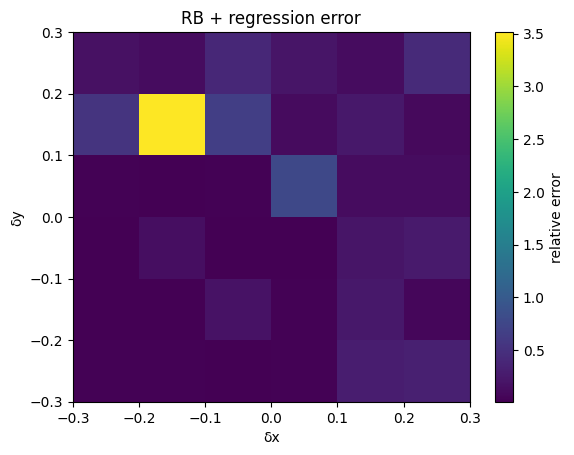

In [ ]:
def compute_error(dx, dy):
    """
    Compare full-order solution vs reduced-order (regressed) solution
    at parameter (dx, dy).
    Returns relative L2 error.
    """
    # --- full order ---
    set_deformation(dx, dy)
    a.Assemble(); f_lin.Assemble()
    gfu_full = GridFunction(V)
    inv = a.mat.Inverse(V.FreeDofs(), inverse="sparsecholesky")
    gfu_full.vec.data = inv * f_lin.vec
    u_full = np.array(gfu_full.vec)

    # --- reduced order (online, from regression) ---
    hat_u, u_rb = solve_online(dx, dy)

    # --- relative error in L2 norm of coefficient vectors ---
    err = np.linalg.norm(u_full - u_rb) / np.linalg.norm(u_full)
    return err

import random

print("Testing error on random parameter points...")
for k in range(5):
    dx_test = random.uniform(-DX_MAX, DX_MAX)
    dy_test = random.uniform(-DY_MAX, DY_MAX)
    err = compute_error(dx_test, dy_test)
    print(f"μ = ({dx_test:.3f}, {dy_test:.3f}), relative error = {err:.2e}")
import matplotlib.pyplot as plt

dx_vals = np.linspace(-DX_MAX, DX_MAX, 6)
dy_vals = np.linspace(-DY_MAX, DY_MAX, 6)
ERR = np.zeros((len(dx_vals), len(dy_vals)))

for i, dxv in enumerate(dx_vals):
    for j, dyv in enumerate(dy_vals):
        ERR[i,j] = compute_error(dxv, dyv)

plt.imshow(ERR.T, origin="lower",
           extent=[-DX_MAX, DX_MAX, -DY_MAX, DY_MAX],
           aspect="auto")
plt.colorbar(label="relative error")
plt.xlabel("δx")
plt.ylabel("δy")
plt.title("RB + regression error")
plt.show()
